<a href="https://colab.research.google.com/github/Alfredo2738/MLwithPyTorch/blob/main/Interactive_Transformer_Block_with_Visualization_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Interactive Transformer Block Experiment ---
Enter Embedding Dimension (d_model, e.g., 64, 128): 128
Enter Number of Attention Heads (must divide embed_dim, e.g., 4 for embed_dim=128): 32
Enter FFN Inner Dimension (d_ff, e.g., 512): 512
Enter Sequence Length (e.g., 10, 20): 20
Enter Batch Size (e.g., 1, 2): 2
Enter Dropout Rate (e.g., 0.1): 0.1

--- Configuration ---
Embedding Dimension (d_model): 128
Number of Attention Heads: 32
FFN Inner Dimension (d_ff): 512
Sequence Length: 20
Batch Size: 2
Dropout Rate: 0.1

Dummy input shape: torch.Size([2, 20, 128])

Output tensor shape after Transformer Block: torch.Size([2, 20, 128])
Attention weights shape: torch.Size([2, 32, 20, 20])

--- Visualizing Transformer Block Architecture ---


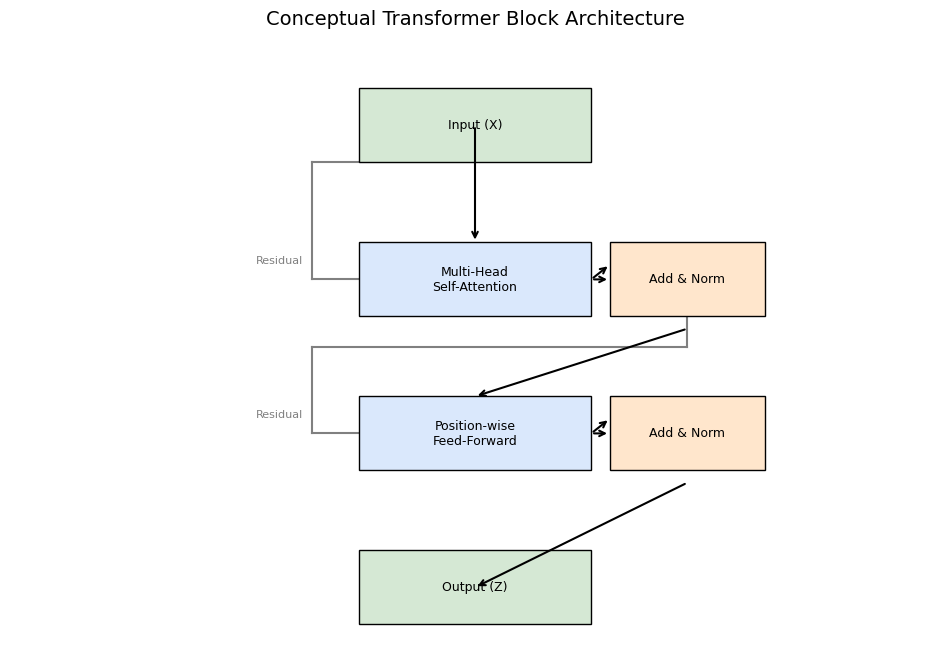


--- Visualizing Tensors (Sample 0 from Batch) ---


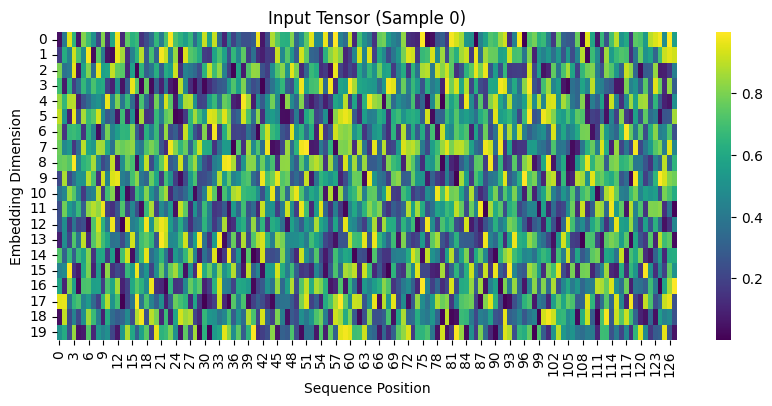

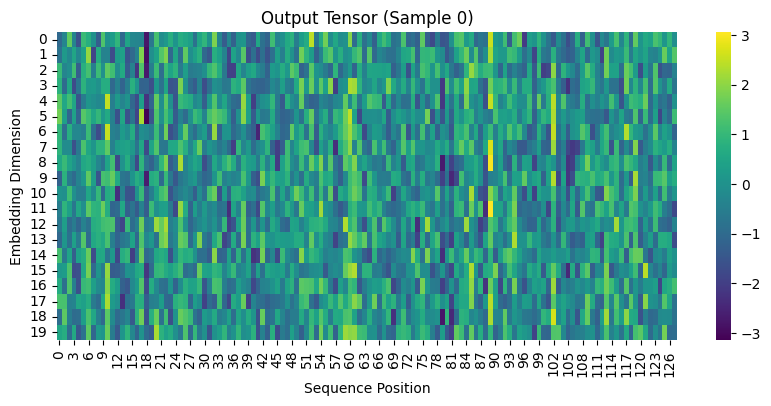


--- Visualizing Attention Head Interaction (Sample 0, Head 0) ---


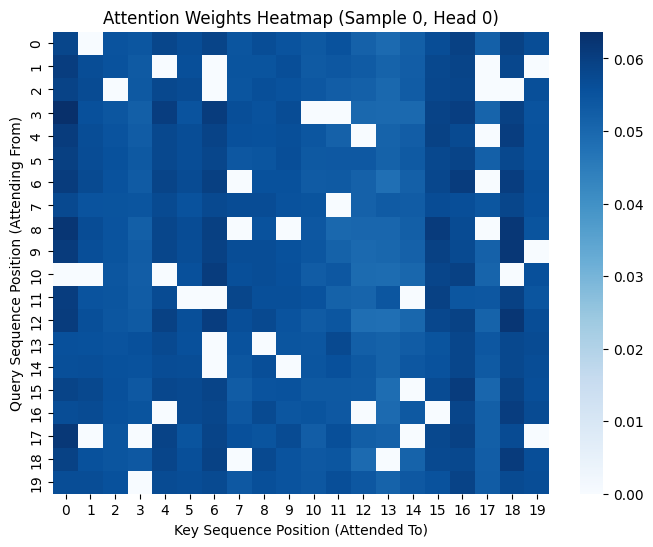

The heatmap above shows attention scores for Sample 0, Head 0.
Each row corresponds to a query position (token attending from).
Each column corresponds to a key position (token being attended to).
Brighter colors indicate stronger attention: the model pays more attention to that key position when processing the query position.

Note: Displaying attention for head 0. There are 32 heads in total.
Each head learns different aspects of relationships in the sequence.
Note: Displaying tensors and attention for sample 0. Batch size is 2.

Experiment finished. Re-run the cell to try different parameters.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

class MultiHeadSelfAttention(nn.Module):
    """
    Implements the Multi-Head Self-Attention mechanism.
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        Args:
            embed_dim (int): The dimensionality of the input and output embeddings.
                             It's also referred to as d_model.
            num_heads (int): The number of attention heads.
            dropout (float): Dropout probability.
        """
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads # Dimension of each head's query, key, value

        # Linear layers for Query, Key, Value projections for all heads
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)

        # Output linear layer
        self.out_linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Computes the scaled dot-product attention.
        Args:
            Q (torch.Tensor): Query tensor, shape (batch_size, num_heads, seq_len_q, head_dim)
            K (torch.Tensor): Key tensor, shape (batch_size, num_heads, seq_len_k, head_dim)
            V (torch.Tensor): Value tensor, shape (batch_size, num_heads, seq_len_v, head_dim)
            mask (torch.Tensor, optional): Mask to be applied to attention scores.
        Returns:
            torch.Tensor: Output tensor after attention, shape (batch_size, num_heads, seq_len_q, head_dim)
            torch.Tensor: Attention weights, shape (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        # MatMul Q and K_transpose
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) # Fill with a very small number

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights) # Apply dropout

        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        """
        Forward pass for Multi-Head Self-Attention.
        Args:
            query (torch.Tensor): Query tensor, shape (batch_size, seq_len_q, embed_dim)
            key (torch.Tensor): Key tensor, shape (batch_size, seq_len_k, embed_dim)
            value (torch.Tensor): Value tensor, shape (batch_size, seq_len_v, embed_dim)
            mask (torch.Tensor, optional): Mask to be applied.
        Returns:
            torch.Tensor: Output tensor, shape (batch_size, seq_len_q, embed_dim)
            torch.Tensor: Attention weights, shape (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        batch_size = query.size(0)

        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Reshape Q, K, V for multi-head processing
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Concatenate heads and apply final linear layer
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        output = self.out_linear(attention_output)
        return output, attention_weights

class PositionwiseFeedForward(nn.Module):
    """
    Implements the Position-wise Feed-Forward Network.
    """
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(embed_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU() # Or GELU

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    """
    Implements a single Transformer Block.
    """
    def __init__(self, embed_dim, num_heads, ffn_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim) # Layer Normalization 1
        self.norm2 = nn.LayerNorm(embed_dim) # Layer Normalization 2
        self.ffn = PositionwiseFeedForward(embed_dim, ffn_dim, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x (torch.Tensor): Input tensor, shape (batch_size, seq_len, embed_dim)
            mask (torch.Tensor, optional): Mask for the self-attention layer.
        Returns:
            torch.Tensor: Output tensor, shape (batch_size, seq_len, embed_dim)
            torch.Tensor: Attention weights from the self-attention layer.
        """
        # Multi-Head Self-Attention sub-layer
        attention_out, attention_weights = self.attention(x, x, x, mask)
        # Residual connection and Layer Normalization
        x_norm1 = self.norm1(x + self.dropout1(attention_out)) # Store for FFN input

        # Position-wise Feed-Forward Network sub-layer
        ffn_out = self.ffn(x_norm1)
        # Residual connection and Layer Normalization
        x_out = self.norm2(x_norm1 + self.dropout2(ffn_out))

        return x_out, attention_weights

def visualize_tensor_heatmap(tensor_data, title, xlabel="Sequence Position", ylabel="Embedding Dimension", cmap="viridis"):
    """ Visualizes a 2D slice of a tensor as a heatmap. """
    plt.figure(figsize=(10, 4))
    sns.heatmap(tensor_data, cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def visualize_attention_weights(attention_weights_data, title, head_index=0, sample_index=0, cmap="Blues"):
    """ Visualizes the attention weights for a specific head and sample. """
    if sample_index >= attention_weights_data.shape[0]:
        print(f"Error: sample_index {sample_index} is out of bounds for batch size {attention_weights_data.shape[0]}. Visualizing sample 0.")
        sample_index = 0
    if head_index >= attention_weights_data.shape[1]:
        print(f"Error: head_index {head_index} is out of bounds for num_heads {attention_weights_data.shape[1]}. Visualizing head 0.")
        head_index = 0

    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_weights_data[sample_index, head_index, :, :], cmap=cmap, cbar=True,
                xticklabels=True, yticklabels=True, annot=False) # annot=True can be too cluttered
    plt.title(f"{title} (Sample {sample_index}, Head {head_index})")
    plt.xlabel("Key Sequence Position (Attended To)")
    plt.ylabel("Query Sequence Position (Attending From)")
    plt.show()
    print(f"The heatmap above shows attention scores for Sample {sample_index}, Head {head_index}.")
    print("Each row corresponds to a query position (token attending from).")
    print("Each column corresponds to a key position (token being attended to).")
    print("Brighter colors indicate stronger attention: the model pays more attention to that key position when processing the query position.")


def visualize_transformer_block_architecture():
    """
    Generates a conceptual block diagram of the Transformer Block architecture.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off') # Turn off axis numbers and ticks

    # Component dimensions and positions
    box_width = 2.5
    box_height = 1.2
    spacing_y = 2.5 # Vertical spacing between main components
    center_x = 5

    # Define component properties
    components = {
        "Input":      {"pos": (center_x, 8.5), "label": "Input (X)", "color": "#D5E8D4"},
        "MHA":        {"pos": (center_x, 8.5 - spacing_y), "label": "Multi-Head\nSelf-Attention", "color": "#DAE8FC"},
        "AddNorm1":   {"pos": (center_x, 8.5 - spacing_y), "label": "Add & Norm", "color": "#FFE6CC", "offset_x": box_width + 0.5}, # To the side of MHA
        "FFN":        {"pos": (center_x, 8.5 - 2*spacing_y), "label": "Position-wise\nFeed-Forward", "color": "#DAE8FC"},
        "AddNorm2":   {"pos": (center_x, 8.5 - 2*spacing_y), "label": "Add & Norm", "color": "#FFE6CC", "offset_x": box_width + 0.5}, # To the side of FFN
        "Output":     {"pos": (center_x, 8.5 - 3*spacing_y), "label": "Output (Z)", "color": "#D5E8D4"}
    }

    # Adjust Add&Norm positions to be after MHA and FFN in the flow
    # We'll draw MHA and FFN first, then place Add&Norm based on their output points.
    # For simplicity in this static diagram, we'll keep them distinct but connect arrows appropriately.

    # Draw components (rectangles and text)
    rects = {}
    for name, props in components.items():
        x, y = props["pos"]
        offset_x = props.get("offset_x", 0) # Default offset is 0

        # Special handling for Add&Norm to place them after their respective main blocks
        if name == "AddNorm1":
             # Position AddNorm1 after MHA output
            x_mha_out = components["MHA"]["pos"][0] + box_width / 2
            y_mha = components["MHA"]["pos"][1]
            rects[name] = patches.Rectangle((x_mha_out + 0.2, y_mha - box_height/2), box_width/1.5, box_height, linewidth=1, edgecolor='black', facecolor=props["color"], zorder=2)
            ax.add_patch(rects[name])
            plt.text(x_mha_out + 0.2 + (box_width/1.5)/2, y_mha, props["label"], ha='center', va='center', fontsize=9, zorder=3)
        elif name == "AddNorm2":
            # Position AddNorm2 after FFN output
            x_ffn_out = components["FFN"]["pos"][0] + box_width / 2
            y_ffn = components["FFN"]["pos"][1]
            rects[name] = patches.Rectangle((x_ffn_out + 0.2, y_ffn - box_height/2), box_width/1.5, box_height, linewidth=1, edgecolor='black', facecolor=props["color"], zorder=2)
            ax.add_patch(rects[name])
            plt.text(x_ffn_out + 0.2 + (box_width/1.5)/2, y_ffn, props["label"], ha='center', va='center', fontsize=9, zorder=3)

        elif name not in ["AddNorm1", "AddNorm2"]: # Draw other components
            rects[name] = patches.Rectangle((x - box_width/2 + offset_x, y - box_height/2), box_width, box_height, linewidth=1, edgecolor='black', facecolor=props["color"], zorder=2)
            ax.add_patch(rects[name])
            plt.text(x + offset_x, y, props["label"], ha='center', va='center', fontsize=9, zorder=3)


    # Draw arrows (connections)
    arrow_props = dict(facecolor='black', arrowstyle='->', connectionstyle='arc3', lw=1.5, zorder=1)

    # Input to MHA
    plt.annotate("", xy=rects["MHA"].get_xy() + np.array([box_width/2, box_height]), xytext=components["Input"]["pos"], arrowprops=arrow_props)

    # MHA to AddNorm1 (main path)
    mha_out_x = rects["MHA"].get_x() + box_width
    mha_out_y = rects["MHA"].get_y() + box_height/2
    addnorm1_in_x = rects["AddNorm1"].get_x()
    addnorm1_in_y = rects["AddNorm1"].get_y() + box_height/2
    plt.annotate("", xy=(addnorm1_in_x, addnorm1_in_y), xytext=(mha_out_x, mha_out_y), arrowprops=arrow_props)

    # AddNorm1 to FFN
    addnorm1_out_x = rects["AddNorm1"].get_x() + rects["AddNorm1"].get_width()/2
    addnorm1_out_y = rects["AddNorm1"].get_y() # bottom center of AddNorm1
    ffn_in_x = rects["FFN"].get_x() + box_width/2
    ffn_in_y = rects["FFN"].get_y() + box_height # top center of FFN
    plt.annotate("", xy=(ffn_in_x, ffn_in_y), xytext=(addnorm1_out_x, addnorm1_out_y - 0.2), arrowprops=arrow_props)


    # FFN to AddNorm2 (main path)
    ffn_out_x = rects["FFN"].get_x() + box_width
    ffn_out_y = rects["FFN"].get_y() + box_height/2
    addnorm2_in_x = rects["AddNorm2"].get_x()
    addnorm2_in_y = rects["AddNorm2"].get_y() + box_height/2
    plt.annotate("", xy=(addnorm2_in_x, addnorm2_in_y), xytext=(ffn_out_x, ffn_out_y), arrowprops=arrow_props)

    # AddNorm2 to Output
    addnorm2_out_x = rects["AddNorm2"].get_x() + rects["AddNorm2"].get_width()/2
    addnorm2_out_y = rects["AddNorm2"].get_y() # bottom center
    output_in_y = rects["Output"].get_y() + box_height/2 # top center
    plt.annotate("", xy=(components["Output"]["pos"][0], output_in_y), xytext=(addnorm2_out_x, addnorm2_out_y - 0.2), arrowprops=arrow_props)

    # Residual Connections
    # Input to AddNorm1 (around MHA)
    input_x_for_residual1 = components["Input"]["pos"][0] - box_width/2 - 0.5 # Start left of Input block
    mha_y_level = components["MHA"]["pos"][1]
    addnorm1_res_in_x = rects["AddNorm1"].get_x()
    addnorm1_res_in_y = rects["AddNorm1"].get_y() + box_height * 0.7 # Connect to upper part of AddNorm1

    # Path: Input -> point left of MHA -> point below MHA -> point left of AddNorm1 -> AddNorm1
    plt.plot([components["Input"]["pos"][0], input_x_for_residual1], [components["Input"]["pos"][1] - box_height/2, components["Input"]["pos"][1] - box_height/2], color='gray', lw=1.5, zorder=0) # out from input
    plt.plot([input_x_for_residual1, input_x_for_residual1], [components["Input"]["pos"][1] - box_height/2, mha_y_level], color='gray', lw=1.5, zorder=0) # down alongside MHA
    plt.plot([input_x_for_residual1, addnorm1_res_in_x - 0.2], [mha_y_level, mha_y_level], color='gray', lw=1.5, zorder=0) # across to AddNorm1
    plt.annotate("", xy=(addnorm1_res_in_x, addnorm1_res_in_y), xytext=(addnorm1_res_in_x - 0.2, mha_y_level),
                 arrowprops=dict(facecolor='gray', arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5, zorder=0))
    plt.text(input_x_for_residual1 - 0.1, mha_y_level + 0.3, "Residual", ha='right', va='center', fontsize=8, color='gray', zorder=3)


    # AddNorm1 output to AddNorm2 (around FFN)
    addnorm1_out_for_residual_x = rects["AddNorm1"].get_x() + rects["AddNorm1"].get_width() + 0.5 # Start right of AddNorm1
    ffn_y_level = components["FFN"]["pos"][1]
    addnorm2_res_in_x = rects["AddNorm2"].get_x()
    addnorm2_res_in_y = rects["AddNorm2"].get_y() + box_height * 0.7 # Connect to upper part of AddNorm2

    # Path: AddNorm1_out -> point right of FFN -> point below FFN -> point left of AddNorm2 -> AddNorm2
    # For simplicity, we'll route from AddNorm1's main output point
    an1_main_out_x = rects["AddNorm1"].get_x() + rects["AddNorm1"].get_width() / 2
    an1_main_out_y = rects["AddNorm1"].get_y() # Bottom of AddNorm1

    # Route from an1_main_out_y, go down, then left, then up to AddNorm2
    point_below_an1_x = an1_main_out_x
    point_below_an1_y = an1_main_out_y - 0.5 # Go down a bit

    point_left_ffn_x = components["FFN"]["pos"][0] - box_width/2 - 0.5 # Left of FFN

    plt.plot([an1_main_out_x, point_below_an1_x], [an1_main_out_y, point_below_an1_y], color='gray', lw=1.5, zorder=0) # Down from AddNorm1
    plt.plot([point_below_an1_x, point_left_ffn_x], [point_below_an1_y, point_below_an1_y], color='gray', lw=1.5, zorder=0) # Across
    plt.plot([point_left_ffn_x, point_left_ffn_x], [point_below_an1_y, ffn_y_level], color='gray', lw=1.5, zorder=0) # Up alongside FFN
    plt.plot([point_left_ffn_x, addnorm2_res_in_x - 0.2], [ffn_y_level, ffn_y_level], color='gray', lw=1.5, zorder=0) # across to AddNorm2
    plt.annotate("", xy=(addnorm2_res_in_x, addnorm2_res_in_y), xytext=(addnorm2_res_in_x - 0.2, ffn_y_level),
                 arrowprops=dict(facecolor='gray', arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5, zorder=0))
    plt.text(point_left_ffn_x - 0.1, ffn_y_level + 0.3, "Residual", ha='right', va='center', fontsize=8, color='gray', zorder=3)


    plt.title("Conceptual Transformer Block Architecture", fontsize=14)
    plt.show()


# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- Interactive Transformer Block Experiment ---")

    # Get hyperparameters from user input
    try:
        embed_dim = int(input("Enter Embedding Dimension (d_model, e.g., 64, 128): ") or "64")
        num_heads = int(input(f"Enter Number of Attention Heads (must divide embed_dim, e.g., 4 for embed_dim={embed_dim}): ") or "4")
        ffn_dim = int(input(f"Enter FFN Inner Dimension (d_ff, e.g., {4*embed_dim}): ") or str(4*embed_dim))
        seq_length = int(input("Enter Sequence Length (e.g., 10, 20): ") or "10")
        batch_size = int(input("Enter Batch Size (e.g., 1, 2): ") or "1") # Default to 1 for clearer single sample viz
        dropout_rate = float(input("Enter Dropout Rate (e.g., 0.1): ") or "0.1")
    except ValueError:
        print("Invalid input. Using default values.")
        embed_dim = 64
        num_heads = 4
        ffn_dim = 256
        seq_length = 10
        batch_size = 1
        dropout_rate = 0.1

    if embed_dim % num_heads != 0:
        print(f"Error: embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads}).")
        print("Please restart and enter valid values.")
        exit()

    print("\n--- Configuration ---")
    print(f"Embedding Dimension (d_model): {embed_dim}")
    print(f"Number of Attention Heads: {num_heads}")
    print(f"FFN Inner Dimension (d_ff): {ffn_dim}")
    print(f"Sequence Length: {seq_length}")
    print(f"Batch Size: {batch_size}")
    print(f"Dropout Rate: {dropout_rate}")

    # Create a dummy input tensor
    dummy_input = torch.rand(batch_size, seq_length, embed_dim)
    print(f"\nDummy input shape: {dummy_input.shape}")

    # Instantiate the Transformer Block
    transformer_block = TransformerBlock(embed_dim, num_heads, ffn_dim, dropout_rate)

    # Pass the dummy input through the Transformer Block
    output_tensor, attention_weights = transformer_block(dummy_input, mask=None)

    print(f"\nOutput tensor shape after Transformer Block: {output_tensor.shape}")
    print(f"Attention weights shape: {attention_weights.shape}")

    # --- Visualizations ---
    print("\n--- Visualizing Transformer Block Architecture ---")
    visualize_transformer_block_architecture() # New visualization call

    print("\n--- Visualizing Tensors (Sample 0 from Batch) ---")
    dummy_input_np = dummy_input.detach().cpu().numpy()
    output_tensor_np = output_tensor.detach().cpu().numpy()
    attention_weights_np = attention_weights.detach().cpu().numpy()

    visualize_tensor_heatmap(dummy_input_np[0, :, :], "Input Tensor (Sample 0)")
    visualize_tensor_heatmap(output_tensor_np[0, :, :], "Output Tensor (Sample 0)")

    print("\n--- Visualizing Attention Head Interaction (Sample 0, Head 0) ---")
    visualize_attention_weights(attention_weights_np, "Attention Weights Heatmap", head_index=0, sample_index=0)

    if num_heads > 1:
        print(f"\nNote: Displaying attention for head 0. There are {num_heads} heads in total.")
        print("Each head learns different aspects of relationships in the sequence.")
    if batch_size > 1:
        print(f"Note: Displaying tensors and attention for sample 0. Batch size is {batch_size}.")

    print("\nExperiment finished. Re-run the cell to try different parameters.")